From Probabilistic-Programming-and-Bayesian-Methods-for-Hackers, Chapter 2 (https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers)

In [1]:
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import theano.tensor as tt

C:\Users\adam\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Challenger Space Shuttle Disaster

On January 28, 1986, the twenty-fifth flight of the U.S. space shuttle program ended in disaster when one of the rocket boosters of the Shuttle Challenger exploded shortly after lift-off, killing all seven crew members. The presidential commission on the accident concluded that it was caused by the failure of an O-ring in a field joint on the rocket booster, and that this failure was due to a faulty design that made the O-ring unacceptably sensitive to a number of factors including outside temperature. Of the previous 24 flights, data were available on failures of O-rings on 23, (one was lost at sea), and these data were discussed on the evening preceding the Challenger launch, but unfortunately only the data corresponding to the 7 flights on which there was a damage incident were considered important and these were thought to show no obvious trend. The data are shown below (see [1]):

Temp (F), O-Ring failure?
[[66.  0.]
 [70.  1.]
 [69.  0.]
 [68.  0.]
 [67.  0.]
 [72.  0.]
 [73.  0.]
 [70.  0.]
 [57.  1.]
 [63.  1.]
 [70.  1.]
 [78.  0.]
 [67.  0.]
 [53.  1.]
 [67.  0.]
 [75.  0.]
 [70.  0.]
 [81.  0.]
 [76.  0.]
 [79.  0.]
 [75.  1.]
 [76.  0.]
 [58.  1.]]


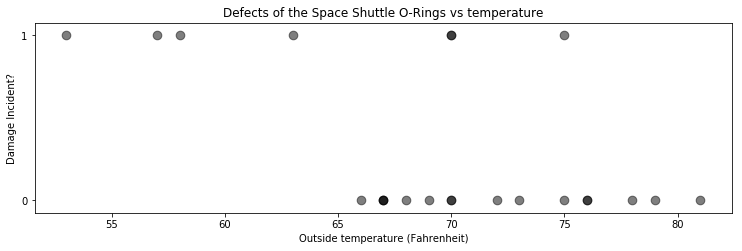

In [2]:
plt.figure(figsize=(12.5, 3.5))
np.set_printoptions(precision=3, suppress=True)
challenger_data = np.genfromtxt("challenger_data.csv", skip_header=1,
                                usecols=[1, 2], missing_values="NA",
                                delimiter=",")
#drop the NA values
challenger_data = challenger_data[~np.isnan(challenger_data[:, 1])]

#plot it, as a function of tempature (the first column)
print("Temp (F), O-Ring failure?")
print(challenger_data)

plt.scatter(challenger_data[:, 0], challenger_data[:, 1], s=75, color="k",
            alpha=0.5)
plt.yticks([0, 1])
plt.ylabel("Damage Incident?")
plt.xlabel("Outside temperature (Fahrenheit)")
plt.title("Defects of the Space Shuttle O-Rings vs temperature");

We need a function of temperature, call it p(t), that is bounded between 0 and 1 (so as to model a probability) and changes from 1 to 0 as we increase temperature. There are actually many such functions, but the most popular choice is the **logistic function**. 
* p(t)=1/1+e**(βt+α)

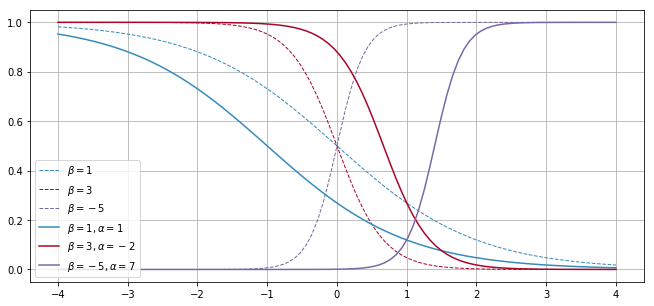

In [3]:
def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

x = np.linspace(-4, 4, 100)

plt.figure(figsize=(11,5))
plt.plot(x, logistic(x, 1), label=r"$\beta = 1$", ls="--", lw=1, color="#348ABD")
plt.plot(x, logistic(x, 3), label=r"$\beta = 3$", ls="--", lw=1, color="#A60628")
plt.plot(x, logistic(x, -5), label=r"$\beta = -5$", ls="--", lw=1, color="#7A68A6")

plt.plot(x, logistic(x, 1, 1), label=r"$\beta = 1, \alpha = 1$",
         color="#348ABD")
plt.plot(x, logistic(x, 3, -2), label=r"$\beta = 3, \alpha = -2$",
         color="#A60628")
plt.plot(x, logistic(x, -5, 7), label=r"$\beta = -5, \alpha = 7$",
         color="#7A68A6")

plt.legend(loc="lower left")
plt.grid()
plt.show()

Let's start modeling this in PyMC3. The β,α parameters have no reason to be positive, bounded or relatively large, so they are best modeled by a Normal random variable.
* X∼N(μ,1/τ)

Samples of normal distribution

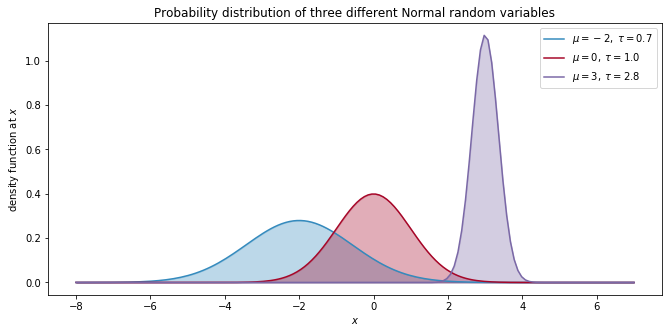

In [4]:
nor = stats.norm
x = np.linspace(-8, 7, 150)
mu = (-2, 0, 3)
tau = (.7, 1, 2.8)
colors = ["#348ABD", "#A60628", "#7A68A6"]
parameters = zip(mu, tau, colors)
plt.figure(figsize=(11,5))

for _mu, _tau, _color in parameters:
    plt.plot(x, nor.pdf(x, _mu, scale=1./_tau),
             label="$\mu = %d,\;\\tau = %.1f$" % (_mu, _tau), color=_color)
    plt.fill_between(x, nor.pdf(x, _mu, scale=1./_tau), color=_color,
                     alpha=.33)
plt.legend(loc="upper right")
plt.xlabel("$x$")
plt.ylabel("density function at $x$")
plt.title("Probability distribution of three different Normal random \
variables");

In [5]:
temperature = challenger_data[:, 0]
D = challenger_data[:, 1]  # defect or not?

#notice the`value` here. We explain why below.
with pm.Model() as model:
    beta = pm.Normal("beta", mu=0, tau=0.001, testval=0) # when τ=0.001, the variance is 1/τ, which is 1000 
    alpha = pm.Normal("alpha", mu=0, tau=0.001, testval=0)
    p = pm.Deterministic("p", 1.0/(1. + tt.exp(beta*temperature + alpha)))

Plot a sample of the Normal Distributions beta or alpha

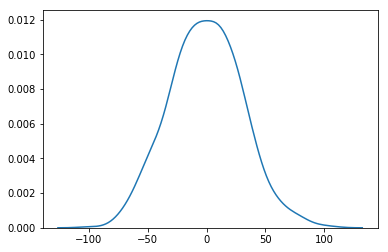

In [6]:
np.random.seed(seed=13)
sam = pm.Normal.dist(mu=0, tau=0.001, testval=0).random(size=1000)
sns.kdeplot(sam)
plt.show()

We see the mean is around 0, and the tails range from -150 to 150. 

In [7]:
per90 = np.percentile(sam, [5,95])
print ("90% of the values lie between:{}".format(per90))
print ("After calculating the posterior of alpha and beta, we will see that they, indeed, lie between these values.")

90% of the values lie between:[-51.834  49.112]
After calculating the posterior of alpha and beta, we will see that they, indeed, lie between these values.


We have our probabilities, but how do we connect them to our observed data? A Bernoulli random variable with parameter p, denoted Ber(p), is a random variable that takes value 1 with probability p, and 0 else. Thus, our model can look like:

Defect Incident, Di∼Ber(p(ti)),i=1..N

where p(t) is our logistic function and ti are the temperatures we have observations about. Notice in the above code we had to set the values of beta and alpha to 0. The reason for this is that if beta and alpha are very large, they make p equal to 1 or 0. Unfortunately, pm.Bernoulli does not like probabilities of exactly 0 or 1, though they are mathematically well-defined probabilities. So by setting the coefficient values to 0, we set the variable p to be a reasonable starting value. This has no effect on our results, nor does it mean we are including any additional information in our prior. It is simply a computational caveat in PyMC3.

In [21]:
with model:
    observed = pm.Bernoulli("bernoulli_obs", p, observed=D)
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(120000, step=step, start=start)
    burned_trace = trace[100000::2]

logp = -19.024, ||grad|| = 9.9071: 100%|██████████████████████████████████████████████| 27/27 [00:00<00:00, 864.01it/s]
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [alpha]
>Metropolis: [beta]
The estimated number of effective samples is smaller than 200 for some parameters.


sidenote: the MAP is the mode of the posterior distribution and is generally found using numerical optimization methods. This is often fast and easy to do, but only gives a point estimate for the parameters and can be biased if the mode isn’t representative of the distribution. 

In [252]:
pm.summary(burned_trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta,0.262450,0.114393,0.010944,0.083028,0.502971,19.798914,1.023956
alpha,-17.054512,7.796072,0.744683,-32.301231,-3.548541,19.885878,1.023887
p__0,0.438774,0.141834,0.005318,0.165232,0.708212,158.954439,1.003600
p__1,0.228728,0.101479,0.003325,0.054611,0.431463,203.555121,1.002354
p__2,0.273396,0.109256,0.001983,0.070807,0.481154,3108.310394,1.000411
p__3,0.324213,0.118744,0.001193,0.102429,0.554530,11682.884234,1.000008
p__4,0.379997,0.129906,0.002934,0.131960,0.628876,915.234864,1.001215
p__5,0.158551,0.088954,0.004880,0.017919,0.334268,58.726945,1.008631
p__6,0.132070,0.083282,0.005156,0.007060,0.294540,45.146743,1.011889
p__7,0.228728,0.101479,0.003325,0.054611,0.431463,203.555121,1.002354


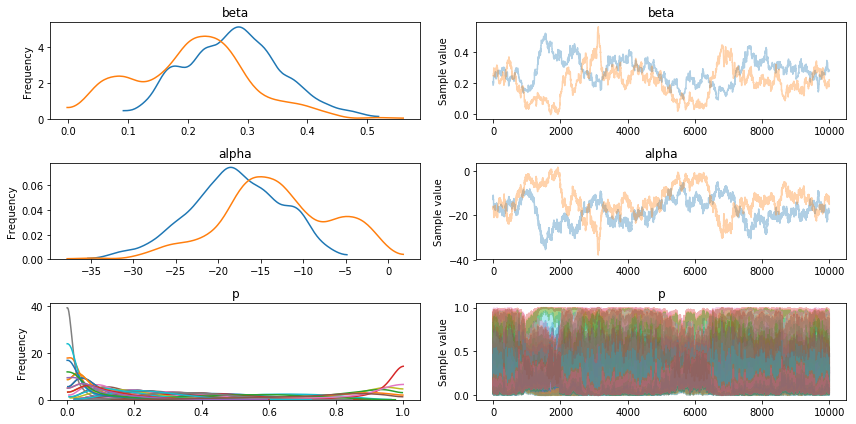

In [22]:
pm.traceplot(burned_trace)
plt.show()

We have trained our model on the observed data, now we can sample values from the posterior. Let's look at the posterior distributions for α and β:

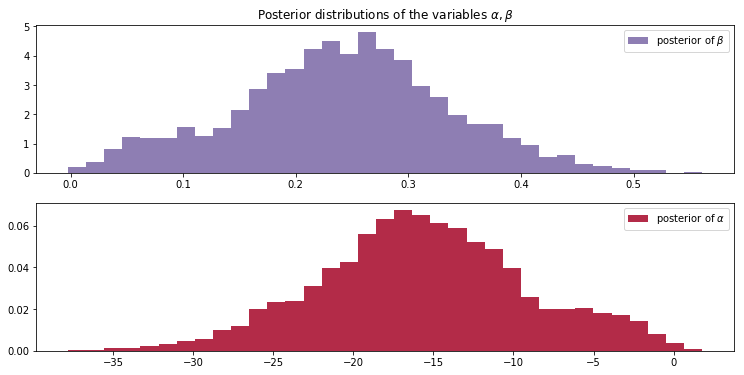

In [23]:
alpha_samples = burned_trace["alpha"][:, None]  # best to make them 1d
beta_samples = burned_trace["beta"][:, None]

plt.figure(figsize=(12.5, 6))

#histogram of the samples:
plt.subplot(211)
plt.title(r"Posterior distributions of the variables $\alpha, \beta$")
plt.hist(beta_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\beta$", color="#7A68A6", normed=True)
plt.legend()

plt.subplot(212)
plt.hist(alpha_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\alpha$", color="#A60628", normed=True)
plt.legend();

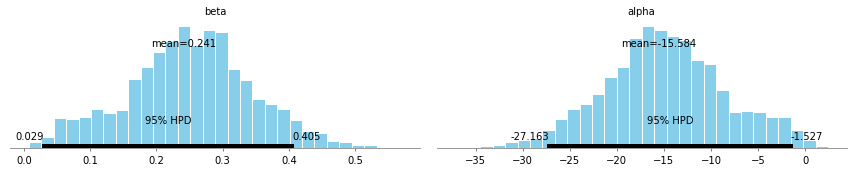

In [24]:
pm.plot_posterior(burned_trace,
                  varnames=['beta','alpha'], 
                  color='#87ceeb')
plt.show()

All samples of β are greater than 0. If instead the posterior was centered around 0, we may suspect that β=0, implying that temperature has no effect on the probability of defect.

Similarly, all α posterior values are negative and far away from 0, implying that it is correct to believe that α is significantly less than 0.

Regarding the spread of the data, we are very uncertain about what the true parameters might be (though considering the low sample size and the large overlap of defects-to-nondefects this behaviour is perhaps expected).

Next, let's look at the expected probability for a specific value of the temperature. That is, we average over all samples from the posterior to get a likely value for p(ti).

In [25]:
def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha)) #same as (1.0/(1. + tt.exp(beta*temperature + alpha)))

t = np.linspace(temperature.min() - 5, temperature.max()+5, 50)[:, None]
p_t = logistic(t.T, beta_samples, alpha_samples)

mean_prob_t = p_t.mean(axis=0)

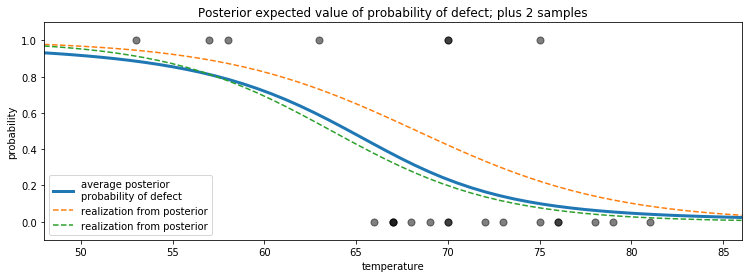

In [26]:
plt.figure(figsize=(12.5, 4))

plt.plot(t, mean_prob_t, lw=3, label="average posterior \nprobability \
of defect")
plt.plot(t, p_t[0, :], ls="--", label="realization from posterior")
plt.plot(t, p_t[-4, :], ls="--", label="realization from posterior")
plt.scatter(temperature, D, color="k", s=50, alpha=0.5)
plt.title("Posterior expected value of probability of defect; \
plus 2 samples")
plt.legend(loc="lower left")
plt.ylim(-0.1, 1.1)
plt.xlim(t.min(), t.max())
plt.ylabel("probability")
plt.xlabel("temperature");

Plot the expected value line and the associated 95% intervals for each temperature.

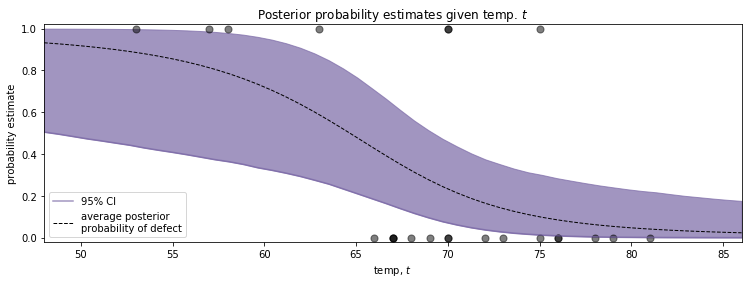

In [27]:
from scipy.stats.mstats import mquantiles

plt.figure(figsize=(12.5, 4))

# vectorized bottom and top 2.5% quantiles for "confidence interval"
qs = mquantiles(p_t, [0.025, 0.975], axis=0)
plt.fill_between(t[:, 0], *qs, alpha=0.7,
                 color="#7A68A6")

plt.plot(t[:, 0], qs[0], label="95% CI", color="#7A68A6", alpha=0.7)

plt.plot(t, mean_prob_t, lw=1, ls="--", color="k",
         label="average posterior \nprobability of defect")

plt.xlim(t.min(), t.max())
plt.ylim(-0.02, 1.02)
plt.legend(loc="lower left")
plt.scatter(temperature, D, color="k", s=50, alpha=0.5)
plt.xlabel("temp, $t$")

plt.ylabel("probability estimate")
plt.title("Posterior probability estimates given temp. $t$");

The 95% credible interval, or 95% CI, painted in purple, represents the interval, for each temperature, that contains 95% of the distribution. For example, at 65 degrees, we can be 95% sure that the probability of defect lies between 0.25 and 0.80.

More generally, we can see that as the temperature nears 60 degrees, the CI's spread out over [0,1] quickly. As we pass 70 degrees, the CI's tighten again. This can give us insight about how to proceed next: we should probably test more O-rings around 60-65 temperature to get a better estimate of probabilities in that range. Similarly, when reporting to scientists your estimates, you should be very cautious about simply telling them the expected probability, as we can see this does not reflect how wide the posterior distribution is.

# Probability of defect at 31 degrees

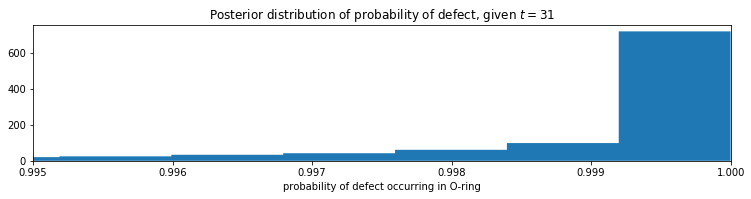

In [19]:
plt.figure(figsize=(12.5, 2.5))

prob_31 = logistic(31, beta_samples, alpha_samples)

plt.xlim(0.995, 1) # expand this if temperature is higher
plt.hist(prob_31, bins=1000, normed=True, histtype='stepfilled')
plt.title("Posterior distribution of probability of defect, given $t = 31$")
plt.xlabel("probability of defect occurring in O-ring");

# Goodness of fit

We can think: how can we test whether our model is a bad fit? An idea is to compare observed data (which if we recall is a fixed stochastic variable) with artificial dataset which we can simulate. The rationale is that if the simulated dataset does not appear similar, statistically, to the observed dataset, then likely our model is not accurately represented the observed data.

In the current example, we sample from the posterior distributions to create very plausible datasets. We only need to create a new Stochastic variable, that is exactly the same as our variable that stored the observations, but minus the observations themselves. If you recall, our Stochastic variable that stored our observed data was:

`observed = pm.Bernoulli("bernoulli_obs", p, observed=D)`

Hence we create:

`simulated_data = pm.Bernoulli("simulation_data", p)`

In [28]:
N = 10000
with pm.Model() as model:
    beta = pm.Normal("beta", mu=0, tau=0.001, testval=0)
    alpha = pm.Normal("alpha", mu=0, tau=0.001, testval=0)
    p = pm.Deterministic("p", 1.0/(1. + tt.exp(beta*temperature + alpha)))
    observed = pm.Bernoulli("bernoulli_obs", p, observed=D)
    
    simulated = pm.Bernoulli("bernoulli_sim", p, shape=p.tag.test_value.shape)
    step = pm.Metropolis(vars=[p])
    trace = pm.sample(N, step=step)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [beta]
>>Metropolis: [alpha]
>BinaryGibbsMetropolis: [bernoulli_sim]
The gelman-rubin statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


(20000, 23)


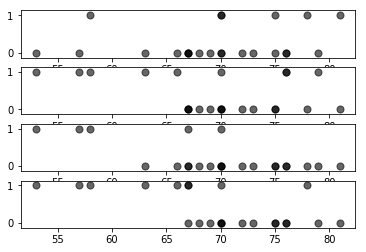

In [30]:
simulations = trace["bernoulli_sim"]
print(simulations.shape)

plt.title("Simulated dataset using posterior parameters")
for i in range(4):
    ax = plt.subplot(4, 1, i+1)
    plt.scatter(temperature, simulations[1000*i, :], color="k",
                s=50, alpha=0.6)

The last 3 plots have resemblance to our original data, however, there are additional ways to diagnose good fit, which we will expand on in other notebooks 